In [1]:
!pip install requests pandas matplotlib wordcloud nltk tqdm


In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm

# Download the VADER sentiment model
nltk.download('vader_lexicon')

# ✅ Put your NewsAPI key here (get from https://newsapi.org/)
NEWS_API_KEY = "5c750f1105c34ecdb91a523cd401daf5"


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
print("Fetching latest technology news from NewsAPI...")

API_URL = (
    f"https://newsapi.org/v2/top-headlines?"
    f"category=technology&"
    f"language=en&"
    f"pageSize=100&"
    f"apiKey={NEWS_API_KEY}"
)

response = requests.get(API_URL)

if response.status_code != 200:
    raise ConnectionError(f"API request failed with status code {response.status_code}")

data = response.json()

# Validate data
if "articles" not in data or len(data["articles"]) == 0:
    raise ValueError("No articles found. Check your NewsAPI key or quota.")

# Convert JSON to DataFrame
df = pd.DataFrame(data["articles"])
df = df[['title', 'description', 'source', 'publishedAt']].dropna()
df['source'] = df['source'].apply(lambda x: x.get('name') if isinstance(x, dict) else x)
df['publishedAt'] = pd.to_datetime(df['publishedAt'])
df = df.sort_values('publishedAt')
print(f"✅ Successfully fetched {len(df)} technology news articles!")
df.head()


Fetching latest technology news from NewsAPI...
✅ Successfully fetched 18 technology news articles!


,title,description,source,publishedAt
17,Elden Ring: Nightreign's The Forsaken Hollows ...,Elden Ring: Nightreign DLC announced at Sony S...,Eurogamer.net,2025-11-11 22:55:55+00:00
16,Gemini in Google Drive can now make Audio Over...,"After NotebookLM, Gemini, and Search, Audio Ov...",9to5google.com,2025-11-11 23:24:00+00:00
15,Octopath Traveler 0 Demo Now Available For Swi...,Get a head start!,Nintendo Life,2025-11-12 02:05:00+00:00
14,"Microsoft Fixes 63 Security Flaws, Including a...","Microsoft fixes 63 flaws, including an exploit...",Internet,2025-11-12 10:21:00+00:00
13,Fei-Fei Li's World Labs speeds up the world mo...,Marble is different from competitors like Odys...,TechCrunch,2025-11-12 13:44:01+00:00


In [4]:
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sid.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

tqdm.pandas()
df['sentiment'] = df['description'].progress_apply(get_sentiment)
df['sentiment'].value_counts()


100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 727.93it/s]


sentiment
positive    9
neutral     6
negative    3
Name: count, dtype: int64

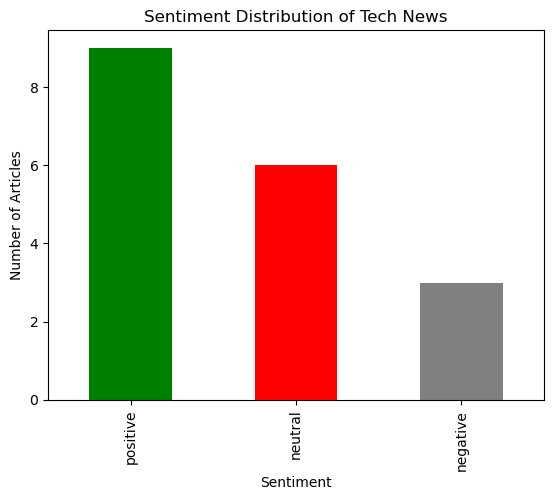

In [5]:
df['sentiment'].value_counts().plot(kind='bar', color=['green','red','gray'])
plt.title('Sentiment Distribution of Tech News')
plt.xlabel('Sentiment')
plt.ylabel('Number of Articles')
plt.show()


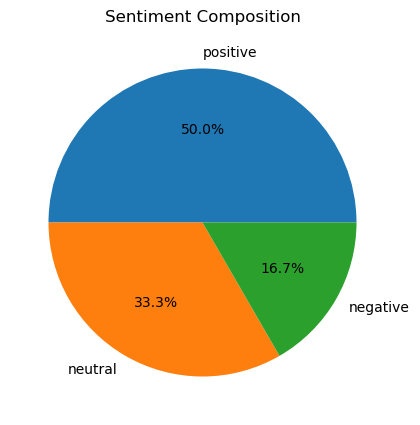

In [6]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(5,5))
plt.title('Sentiment Composition')
plt.ylabel('')
plt.show()


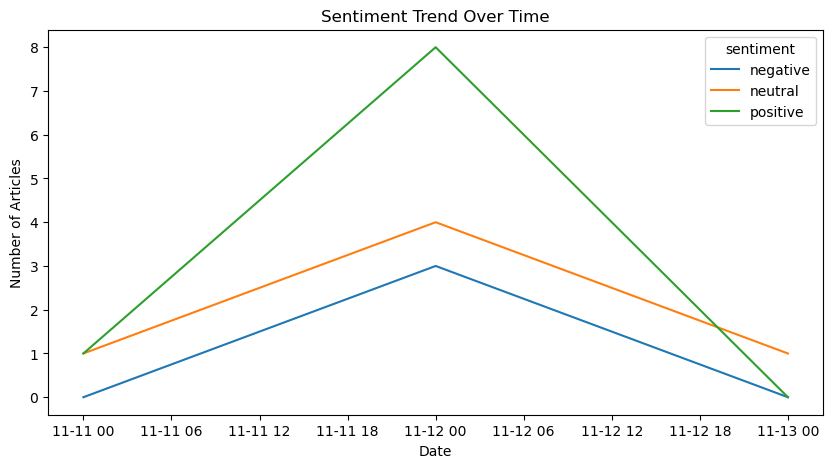

In [7]:
trend = df.groupby([df['publishedAt'].dt.date, 'sentiment']).size().unstack(fill_value=0)
trend.plot(kind='line', figsize=(10,5))
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.show()


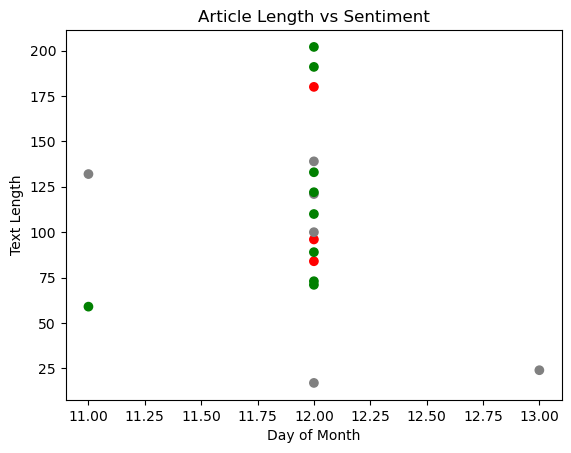

In [8]:
df['text_length'] = df['description'].apply(lambda x: len(str(x)))
colors = {'positive':'green', 'negative':'red', 'neutral':'gray'}
plt.scatter(df['publishedAt'].dt.day, df['text_length'], c=df['sentiment'].map(colors))
plt.title('Article Length vs Sentiment')
plt.xlabel('Day of Month')
plt.ylabel('Text Length')
plt.show()


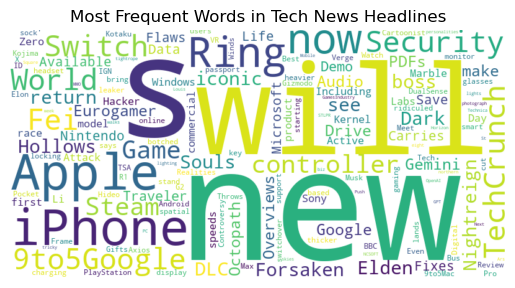

In [9]:
text = ' '.join(df['title'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Tech News Headlines')
plt.show()


In [10]:
df.to_csv("tech_news_sentiment_results.csv", index=False)
print("✅ Results saved to tech_news_sentiment_results.csv")


✅ Results saved to tech_news_sentiment_results.csv
